[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anutri03/ML-AI-prep/blob/main/NLP/TrueFakenewsclassificationn.ipynb)


In [1]:
!pip install -q scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re # regular expression

In [3]:
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM ,Dense , Dropout
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report


In [4]:
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from nltk.tokenize import word_tokenize

print("libraries loaded")
#print it

libraries loaded


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
!wget -q https://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


In [6]:
embedding_index = {}
with open('glove.6B.100d.txt',encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedding_index[word] = coefs

print(f'loaded {len(embedding_index)} word vectors.')

loaded 400000 word vectors.


In [7]:
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

In [8]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
true_df['label'] = 1
fake_df['label'] = 0

In [10]:
data = pd.concat([true_df,fake_df],axis=0).reset_index(drop=True)
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [11]:
data.shape

(44898, 5)

In [12]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^a-zA-Z0-9\s]','',text)
  text = re.sub(r'\W',' ',text)
  text = re.sub(r'\s+',' ',text) # remove extra spaces
  text = re.sub(r'\d',' ',text)
  word = text.split()
  word = [w for w in word if w not in stopwords]
  text = ' '.join(word)
  return text

data['text'] = data['text'].apply(clean_text)
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",washington reuters head conservative republica...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,washington reuters transgender people allowed ...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington reuters special counsel investigati...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,washington reuters trump campaign adviser geor...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,seattlewashington reuters president donald tru...,politicsNews,"December 29, 2017",1


In [13]:
# tokeniztion and padding
max_words = 5000
maX_len = 200

tokenizer = Tokenizer(num_words=max_words) #tokenizer model
tokenizer.fit_on_texts(data['text']) # fit train on the text data
sequences = tokenizer.texts_to_sequences(data['text']) # into seq
padded_sequences = pad_sequences(sequences,maxlen=maX_len) # seq len

X = padded_sequences
y = data['label'].values


In [14]:
len(X)

44898

In [15]:
len(y)

44898

In [16]:
embedding_dim = 100 # using glove 100d
embedding_matrix = np.zeros((max_words,embedding_dim))

for word, i in tokenizer.word_index.items():
  if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [17]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13128   , -0.45199999,  0.043399  , ..., -0.30526   ,
        -0.045495  ,  0.56509   ],
       [-0.15730999, -0.75502998,  0.36844999, ..., -0.54136997,
         0.67817003, -0.17251   ],
       ...,
       [ 0.85189003,  0.35648999,  0.14484   , ...,  0.57959002,
         0.82071   , -0.23049   ],
       [-0.072362  , -0.18979   ,  0.92119002, ..., -0.47580001,
        -0.36036   ,  0.26363   ],
       [ 0.01919   ,  0.11263   ,  0.089312  , ...,  0.31529999,
         0.37362   , -0.83552998]])

In [18]:
from sklearn.model_selection import train_test_split
X_train , X_test ,y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35918, 200), (8980, 200), (35918,), (8980,))

In [20]:
model = Sequential([
          Embedding(max_words,embedding_dim,input_length=maX_len ,weights=[embedding_matrix],trainable=False),
          LSTM(128,return_sequences=True),
          Dropout(0.2),
          LSTM(64),
          Dropout(0.2),
          Dense(1,activation='sigmoid')])


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()







/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

In [21]:
history = model.fit(X_train,y_train,epochs=5,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.8918 - loss: 0.2618 - val_accuracy: 0.9862 - val_loss: 0.0404
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9819 - loss: 0.0543 - val_accuracy: 0.9804 - val_loss: 0.0629
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9855 - loss: 0.0422 - val_accuracy: 0.9903 - val_loss: 0.0293
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.9892 - loss: 0.0287 - val_accuracy: 0.9914 - val_loss: 0.0240
Epoch 5/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9921 - loss: 0.0223 - val_accuracy: 0.9934 - val_loss: 0.0196


In [22]:
loss , accuracy = model.evaluate(X_test,y_test)
print(f'loss : {loss} , accuracy : {accuracy}')

281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9936 - loss: 0.0194
loss : 0.01963256672024727 , accuracy : 0.9934298396110535


In [23]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [24]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4650
           1       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Text(0.5, 1.0, 'confusion matrix')

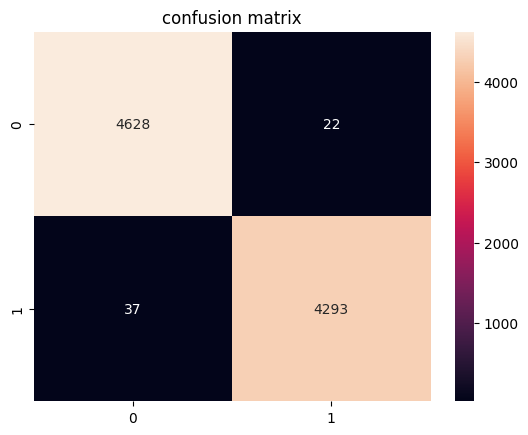

In [26]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt = 'd')
plt.title('confusion matrix')

In [27]:
def predict_news(news):
  news = clean_text(news)
  seq = tokenizer.texts_to_sequences([news])
  padded = pad_sequences(seq,maxlen=maX_len)
  pred = model.predict(padded)[0][0]

  if pred>=0.5:
    print("Real News")
  else:
    print("Fake News")
while True:
  user_input = input("Enter a news headline (or 'exit' to quit): ")
  if user_input.lower() == 'exit':
    break
  predict_news(user_input)###

Enter a news headline (or 'exit' to quit): hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Fake News
Enter a news headline (or 'exit' to quit): exit
